In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix, recall_score, mean_squared_error, f1_score
from shapely.geometry import Point, LineString, Polygon
import shap
import numpy as np
from sklearn.impute import SimpleImputer


#create a file path to import resoucre file
file_path = os.path.join('Resource', 'Plan A Task ML_final.xlsx')

In [31]:

df_labor = pd.read_excel(file_path, sheet_name='Department of Labor')
df_commerce = pd.read_excel(file_path, sheet_name='Department of Commerce')



In [3]:
# Drop NaN rows and columns
df_labor_cleaned = df_labor.dropna(axis=0, how='all').dropna(axis=1, how='all')

# print("Department Labor:")
# print(df_labor_cleaned)

In [4]:
#choose which columns to pull
experince_q = ['Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7']

#create df
experince_df = df_labor_cleaned[experince_q].copy()

# Convert columns to numeric, handling errors and converting NaN to a placeholder value
experince_df[experince_q] = experince_df[experince_q].apply(pd.to_numeric, errors='coerce')

# Standardize all the numerical data
experince_df = experince_df.round().astype('Int64')

#dict for renaming the columns
q_names = {
    'Q85': 'Inspire',
    'Q86': 'Accomplishment',
    'Q87': 'Attachment',
    'Q88': 'Identify',
    'Q89': 'Contribute',
    'Q2': 'Encouraged',
    'Q3': 'Personal',
    'Q4': 'Expected',
    'Q6': 'Talent',
    'Q7': 'Relate'
}

# 5	Strongly Agree
# 4	Agree
# 3	Neither Agree nor Disagree
# 2	Disagree
# 1	Strongly Disagree


#rename columns
experince_df.rename(columns=q_names, inplace=True)

#count occurrences of each value in each column
experince_count = {}

for column in experince_df.columns:
    value_counts = experince_df[column].value_counts().sort_index()
    experince_count[column] = value_counts
    
# #display counts
# for column, counts in experince_count.items():
#     print(f"\nCounts for {column}:")
#     print(counts)

    
# Define a threshold for the number of blanks
blank_threshold = 5  # You can adjust this threshold

# Identify rows with a large number of blanks
rows_to_drop = experince_df[experince_df.isnull().sum(axis=1) >= blank_threshold].index

# # Drop identified rows
# experince_df.drop(index=rows_to_drop, inplace=True)
print(rows_to_drop)

# Define a threshold for missing values
missing_threshold = 0.1  # 10%

# Identify variables with more than 10% missing values
columns_to_drop = experince_df.columns[experince_df.isnull().mean() > missing_threshold]

# # Drop identified variables
# experince_df.drop(columns=columns_to_drop, inplace=True)
print(columns_to_drop)
#display
# print("experince df")
# print(experince_df.head(20))

Index([ 176,  201,  260,  291,  313,  350,  358,  384,  387,  447,
       ...
       7262, 7317, 7318, 7356, 7465, 7480, 7498, 7499, 7510, 7524],
      dtype='int64', length=248)
Index([], dtype='object')


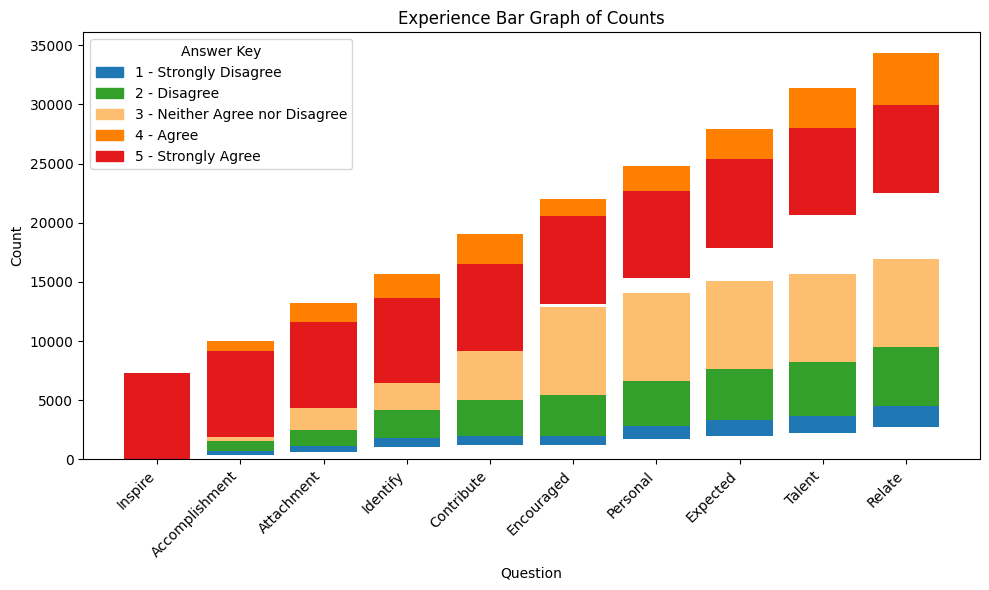

In [5]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each response level
colors = ['#1f78b4', '#33a02c', '#fdbf6f', '#ff7f00', '#e31a1c']

# Iterate through each column in experince_count and plot a stacked bar
bottom = np.zeros(len(experince_count), dtype='float64')
for i, (column, counts) in enumerate(experince_count.items()):
    ax.bar(i, counts.sum(), label=column, color=colors, bottom=bottom[:len(counts)])
    bottom[:len(counts)] += counts  

# Add a custom legend for the answer key
legend_labels = ['Strongly Disagree', 'Disagree', 'Neither Agree nor Disagree', 'Agree', 'Strongly Agree']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=f'{i + 1} - {label}') for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='Answer Key', loc='upper left')

# Set labels and title
ax.set_xlabel('Question')
ax.set_ylabel('Count')
ax.set_title('Experience Bar Graph of Counts')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(experince_count)))
ax.set_xticklabels(experince_count.keys(), rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()



In [6]:
# Choose which columns to pull
leadership_q = ['Q71', 'Q72', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52']

# Create DataFrame by explicitly making a copy
leadership_df = df_labor_cleaned[leadership_q].copy()

# Replace 'X' with 0 in the entire DataFrame
leadership_df.replace('X', 0, inplace=True)

# Standardize only the numerical values
for col in leadership_q:
    if leadership_df[col].dtype.kind == 'f':
        leadership_df[col] = round(pd.to_numeric(leadership_df[col], errors='coerce')).astype('Int64')

# Dictionary for renaming the columns
leadership_names = {
    'Q71': 'Diversity',
    'Q72': 'Demonstrates',
    'Q55': 'Attachment',
    'Q56': 'Standards',
    'Q57': 'Communicate',
    'Q59': 'Good Manager',
    'Q60': 'Respect',
    'Q46': 'Development',
    'Q48': 'Listens',
    'Q49': 'Respect',
    'Q50': 'Trust',
    'Q52': 'Good Supervisor'
}

# 5	Strongly Agree
# 4	Agree
# 3	Neither Agree nor Disagree
# 2	Disagree
# 1	Strongly Disagree
# 0	Do Not Know

# Rename columns
leadership_df.rename(columns=leadership_names, inplace=True)

# Drop the 'Respect' column if it exists
if 'Respect' in leadership_df.columns:
    leadership_df = leadership_df.drop(columns=['Respect'])

# Count occurrences of each value in each column
leadership_counts = {}

for column in leadership_df.columns:
    value_counts = leadership_df[column].value_counts().sort_index()
    leadership_counts[column] = value_counts

# Display counts
for column, counts in leadership_counts.items():
    print(f"\nCounts for {column}:")
    print(counts)


# # Display
# print("Leadership DataFrame:")
# print(leadership_df.head(20))



Counts for Diversity:
Diversity
0     737
1     303
2     360
3     958
4    2568
5    2421
Name: count, dtype: Int64

Counts for Demonstrates:
Demonstrates
0     725
1     235
2     226
3     894
4    2389
5    2880
Name: count, dtype: Int64

Counts for Attachment:
Attachment
0     242
1     789
2     826
3    1466
4    2501
5    1551
Name: count, dtype: Int64

Counts for Standards:
Standards
0     630
1     569
2     394
3    1222
4    2482
5    2044
Name: count, dtype: Int64

Counts for Communicate:
Communicate
0     100
1     406
2     442
3     988
4    3346
5    2058
Name: count, dtype: Int64

Counts for Good Manager:
Good Manager
0     388
1     445
2     410
3    1096
4    2268
5    2777
Name: count, dtype: Int64

Counts for Development:
Development
0     138
1     280
2     320
3     779
4    2478
5    3432
Name: count, dtype: Int64

Counts for Listens:
Listens
1     221
2     277
3     547
4    2189
5    4123
Name: count, dtype: Int64

Counts for Trust:
Trust
1     321
2    

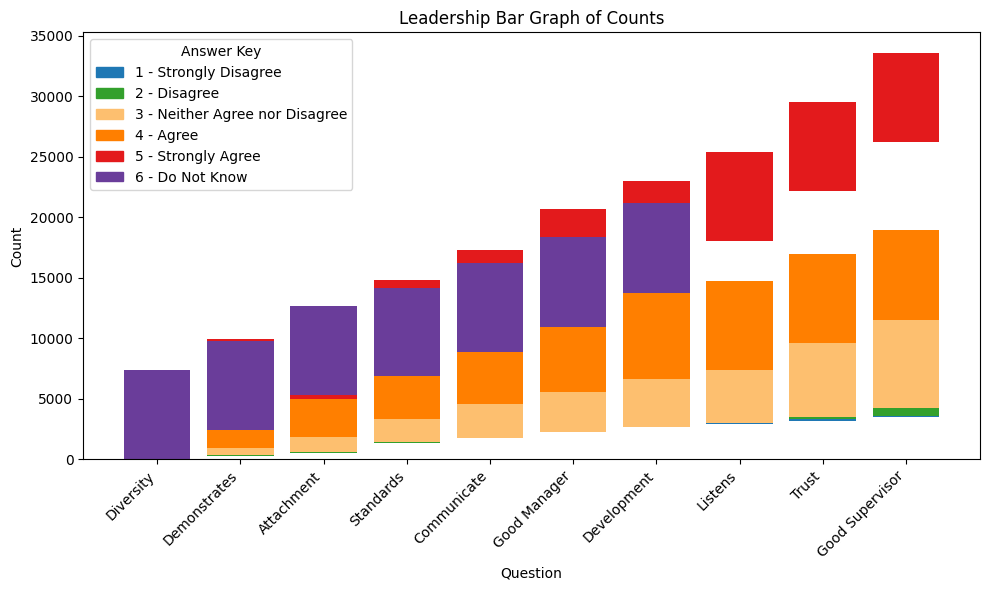

In [7]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each response level
colors = ['#1f78b4', '#33a02c', '#fdbf6f', '#ff7f00', '#e31a1c', '#6a3d9a']


# Iterate through each column in experince_count and plot a stacked bar
bottom = np.zeros(len(leadership_counts), dtype='float64')
for i, (column, counts) in enumerate(leadership_counts.items()):
    ax.bar(i, counts.sum(), label=column, color=colors, bottom=bottom[:len(counts)])
    bottom[:len(counts)] += counts  

# Add a custom legend for the answer key
legend_labels = ['Strongly Disagree', 'Disagree', 'Neither Agree nor Disagree', 'Agree', 'Strongly Agree', 'Do Not Know']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=f'{i + 1} - {label}') for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='Answer Key', loc='upper left')

# Set labels and title
ax.set_xlabel('Question')
ax.set_ylabel('Count')
ax.set_title('Leadership Bar Graph of Counts')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(leadership_counts)))
ax.set_xticklabels(leadership_counts.keys(), rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()



In [8]:
# Choose which columns to pull
accessibility_q = ['Q84']

# Create DataFrame by explicitly making a copy
accessibility_df = df_labor_cleaned[accessibility_q].copy()

# Dictionary for renaming the columns
acc_names = {
    'Q84': 'Accessibilty',
}

# 5 Strongly Agree
# 4 Agree
# 3 No Accessibility Needs
# 2 Disagree
# 1 Strongly Disagree

# Rename columns
accessibility_df.rename(columns=acc_names, inplace=True)

# Combine 'Y' and 'X' into a single category
accessibility_df['Accessibilty'] = accessibility_df['Accessibilty'].replace(['Y', 'X'], '3')

# Convert the 'Accessibility' column to string type
accessibility_df['Accessibilty'] = accessibility_df['Accessibilty'].astype(str)

# Count occurrences of each value in the 'Accessibility' column
accessibility_counts = accessibility_df['Accessibilty'].value_counts().sort_index()



# # Display counts
# print("Counts for Accessibility:")
# print(accessibility_counts)

# # Display
# print("Accessibilty DataFrame:")
# print(accessibility_df)


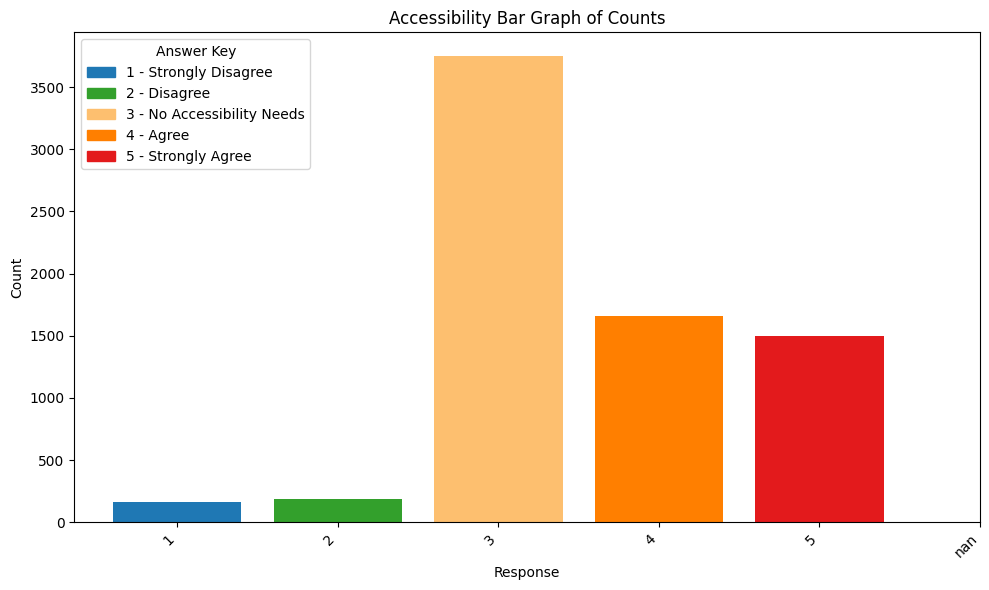

In [9]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each response level
colors = ['#1f78b4', '#33a02c', '#fdbf6f', '#ff7f00', '#e31a1c']

# Iterate through each value in accessibility_counts and plot a bar
for i, (value, count, color) in enumerate(zip(accessibility_counts.index, accessibility_counts, colors)):
    ax.bar(i, count, color=color, label=f'{i + 1} - {value}')

# Add a custom legend for the answer key
legend_labels = ['Strongly Disagree', 'Disagree', 'No Accessibility Needs', 'Agree', 'Strongly Agree']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=f'{i + 1} - {label}') for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='Answer Key', loc='upper left')

# Set labels and title
ax.set_xlabel('Response')
ax.set_ylabel('Count')
ax.set_title('Accessibility Bar Graph of Counts')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(accessibility_counts)))
ax.set_xticklabels(accessibility_counts.index, rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [10]:
# Choose which columns to pull
demo_q = ['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL']

# Create DataFrame by explicitly making a copy
demo_df= df_labor_cleaned[demo_q].copy()

# DRNO: 
# 1)	Black or African American 
# 2)	White 
# 3)	Asian 
# 4)	Other Groups Collapsed for Privacy
# DHISP/DDIS:
# 1)	Yes 
# 2)	No 
# DAGEGRP:
# 1)	Under 40
# 2)	40 or Older
# DSUPER:
# 1)	Non-Supervisor/Team Leader
# 2)	Supervisor/Manager/Executive
# DFEDTEN:
# 1)	Ten years or fewer
# 2)	Eleven to 20 years
# 3)	More than 20 years
# DSEX:
# 1)	Male 
# 2)	Female
# DMIL:
# 1)	Military Service
# 2)	No Prior Military Service

#Define a mapping for replacement
replacement_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

# Apply the replacement to each specified column
for column in demo_q:
    demo_df[column] = demo_df[column].map(replacement_mapping).astype('Int64')

# Count occurrences of each value in each column
demo_counts = {}

for column in demo_df.columns:
    value_counts = demo_df[column].value_counts().sort_index()
    demo_counts[column] = value_counts

# Display counts
for column, counts in demo_counts.items():
    print(f"\nCounts for {column}:")
    print(counts)


# # Display
# print("Demographic DataFrame:")
# print(demo_df.head(20))


Counts for DRNO:
DRNO
1    1160
2    4040
3     393
4     208
Name: count, dtype: Int64

Counts for DHISP:
DHISP
1     684
2    5631
Name: count, dtype: Int64

Counts for DDIS:
DDIS
1    1220
2    5297
Name: count, dtype: Int64

Counts for DAGEGRP:
DAGEGRP
1    1451
2    5075
Name: count, dtype: Int64

Counts for DSUPER:
DSUPER
1    5212
2    1770
Name: count, dtype: Int64

Counts for DFEDTEN:
DFEDTEN
1    2299
2    2512
3    2164
Name: count, dtype: Int64

Counts for DSEX:
DSEX
1    3127
2    3407
Name: count, dtype: Int64

Counts for DMIL:
DMIL
1    1670
2    5328
Name: count, dtype: Int64


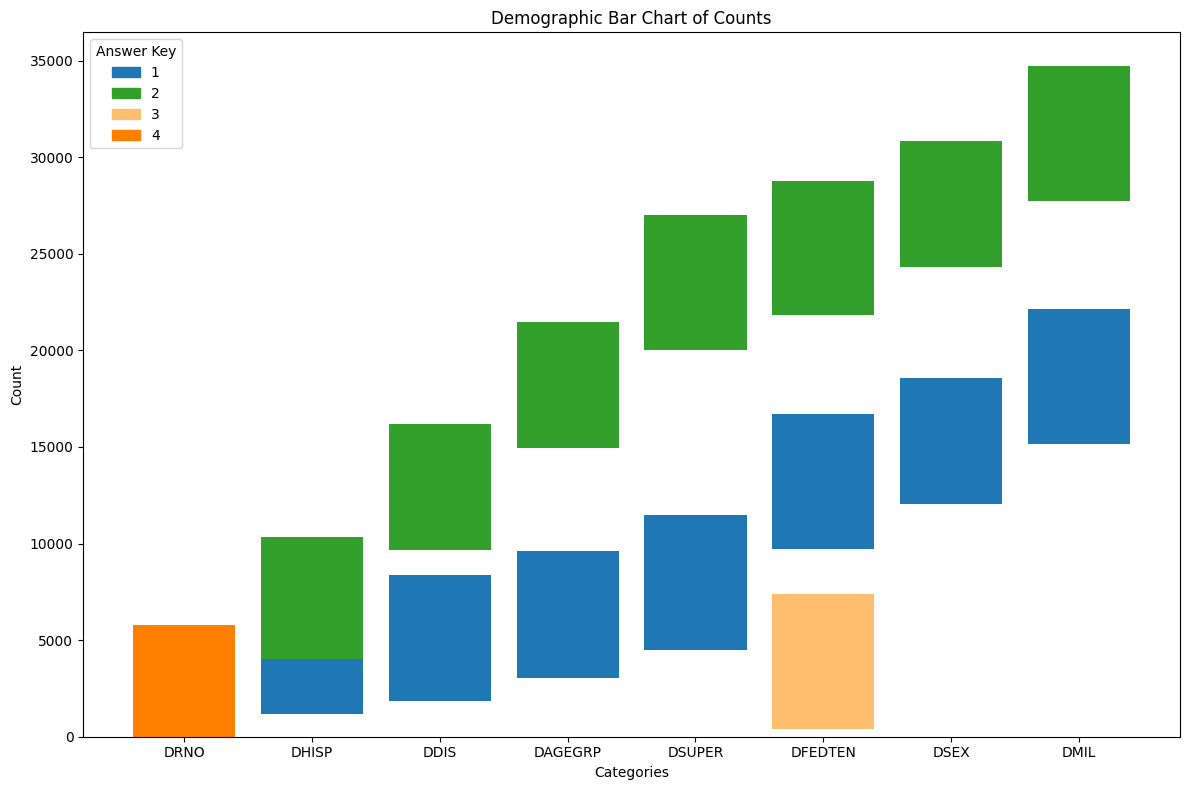

In [11]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each response level
colors = ['#1f78b4', '#33a02c', '#fdbf6f', '#ff7f00', '#e31a1c', '#6a3d9a']

# Iterate through each column in demo_counts and plot a stacked bar
bottom = np.zeros(len(demo_counts), dtype='float64')
for i, (column, counts) in enumerate(demo_counts.items()):
    ax.bar(column, counts.sum(), color=colors, bottom=bottom[:len(counts)], label=column)
    bottom[:len(counts)] += counts

# Add a simple legend with labels 1, 2, 3, 4
legend_labels = ['1', '2', '3', '4']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_handles, title='Answer Key', loc='upper left')

# Set labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_title('Demographic Bar Chart of Counts')

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Choose which columns to pull
outcome_q = ['DLEAVING']

# Create DataFrame by explicitly making a copy
outcome_df = df_labor_cleaned[outcome_q].copy()

# DLEAVING
# 0)	No 
# 1)	Yes   
# Count occurrences of each value in each column

# Choose which columns to pull
outcome_q = ['DLEAVING']

# Create DataFrame by explicitly making a copy
outcome_df = df_labor_cleaned[outcome_q].copy()

# Map values to numeric codes
outcome_df['DLEAVING'] = outcome_df['DLEAVING'].map({'A': 0, 'B': 1, 'C': 1, 'D': 1})

# Display counts
outcome_counts = outcome_df['DLEAVING'].value_counts()
print("Counts for DLEAVING:")
print(outcome_counts)

# # Display
# print("Outcome DataFrame:")
# print(outcome_df.head(20))

Counts for DLEAVING:
DLEAVING
0.0    4779
1.0    2245
Name: count, dtype: int64


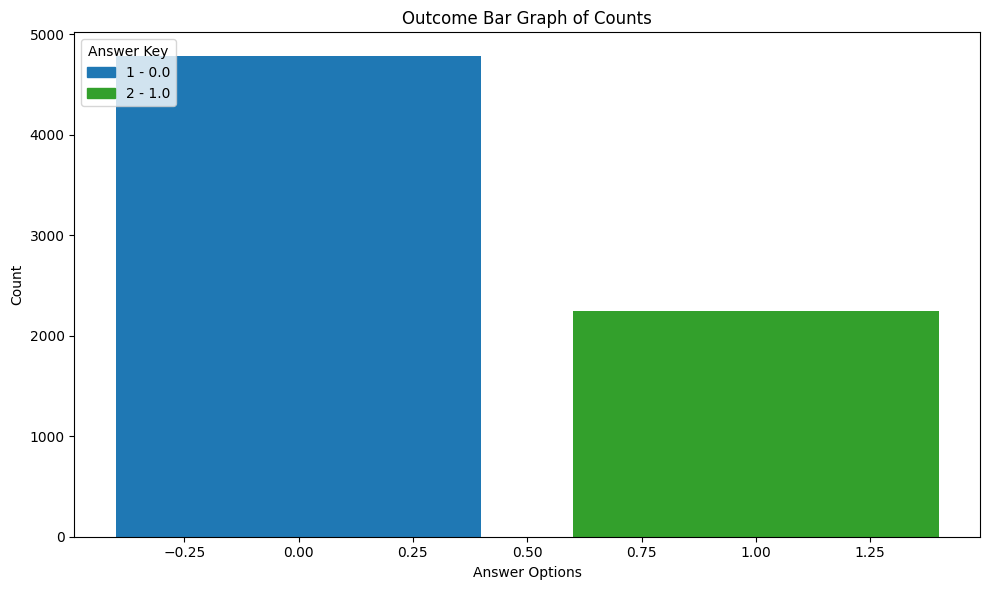

In [13]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each response level
colors = ['#1f78b4', '#33a02c']

# Plot a bar for each answer option
for i, (answer, count) in enumerate(outcome_counts.items()):
    ax.bar(i, count, color=colors[i], label=f'{i + 1} - {answer}')

# Add a custom legend for the answer key
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=f'{i + 1} - {answer}') for i, (answer, count) in enumerate(outcome_counts.items())]
ax.legend(handles=legend_handles, title='Answer Key', loc='upper left')

# Set labels and title
ax.set_xlabel('Answer Options')
ax.set_ylabel('Count')
ax.set_title('Outcome Bar Graph of Counts')

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
# Combine DataFrames along the columns
combined_df = pd.concat([outcome_df, demo_df, accessibility_df, leadership_df, experince_df], axis=1)

# # Display the combined DataFrame
# print("Combined DataFrame:")
# print(combined_df.head())

<Axes: >

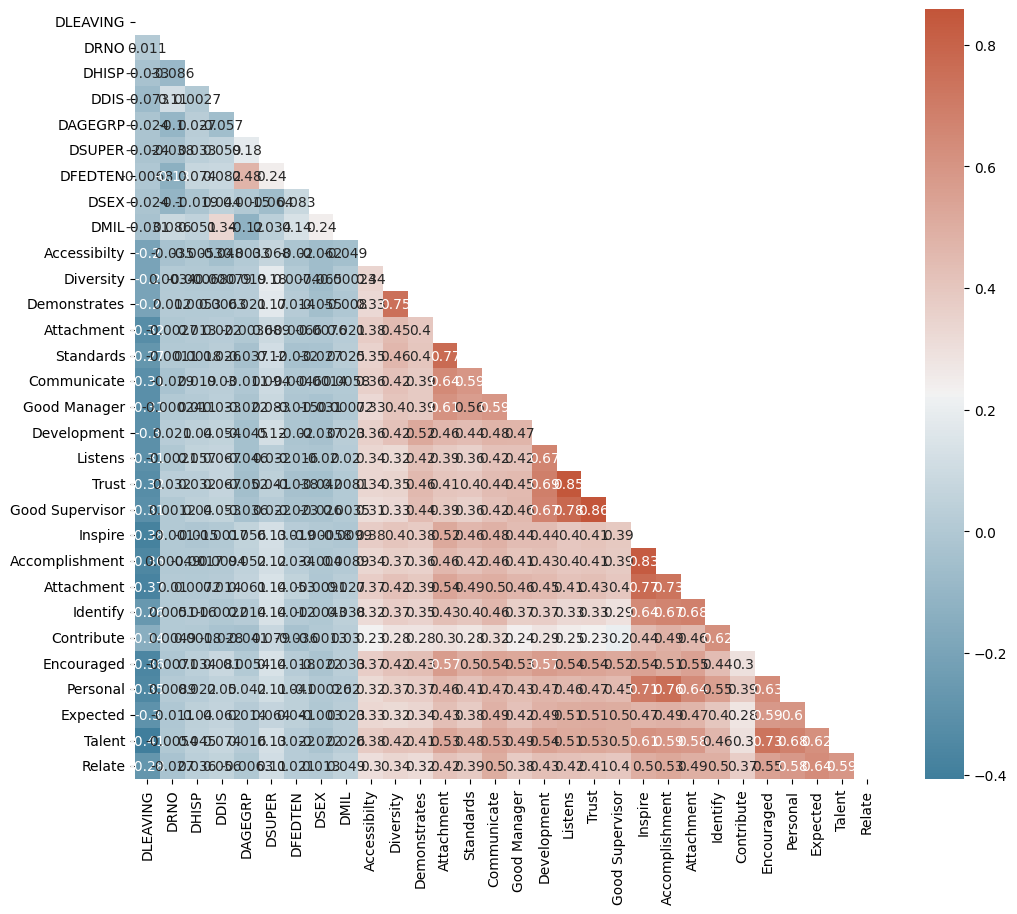

In [15]:
# Create a correlation matrix
correlation_matrix = combined_df.corr()

# Set up the matplotlib plot configuration
ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, mask = mask, cmap=cmap)

In [16]:
# Identify variables with correlation greater than 0.8
highly_correlated_vars = correlation_matrix.abs() > 0.8

# Iterate over the upper triangle of the correlation matrix
correlated_vars = set()

for i in range(len(highly_correlated_vars.columns)):
    for j in range(i + 1, len(highly_correlated_vars.columns)):
        if highly_correlated_vars.iloc[i, j]:
            correlated_vars.add((highly_correlated_vars.columns[i], highly_correlated_vars.columns[j]))

# Display correlated variables
for var_pair in correlated_vars:
    print(f"Variable pair correlated: {var_pair}")

# Display the updated dataframe
print(combined_df)
    


Variable pair correlated: ('Listens', 'Trust')
Variable pair correlated: ('Inspire', 'Accomplishment')
Variable pair correlated: ('Trust', 'Good Supervisor')
      DLEAVING  DRNO  DHISP  DDIS  DAGEGRP  DSUPER  DFEDTEN  DSEX  DMIL  \
0          0.0     2      2     2        2       2        2     1     2   
1          0.0     2      2     2        2       1        2     2     2   
2          0.0     2      2     1        2       1        1     1     1   
3          1.0     2      2     2        1       1        1     2     1   
4          1.0     2      1     2        1       1        1     1     2   
...        ...   ...    ...   ...      ...     ...      ...   ...   ...   
7545       0.0     1      2     2        1       1        1     1     2   
7546       1.0     3      2     2        1       1        1     2     2   
7547       0.0     3      2     2        1       1        1     2     2   
7548       0.0     2      2     2        1       1        1     2     2   
7549       1.0   

<Axes: >

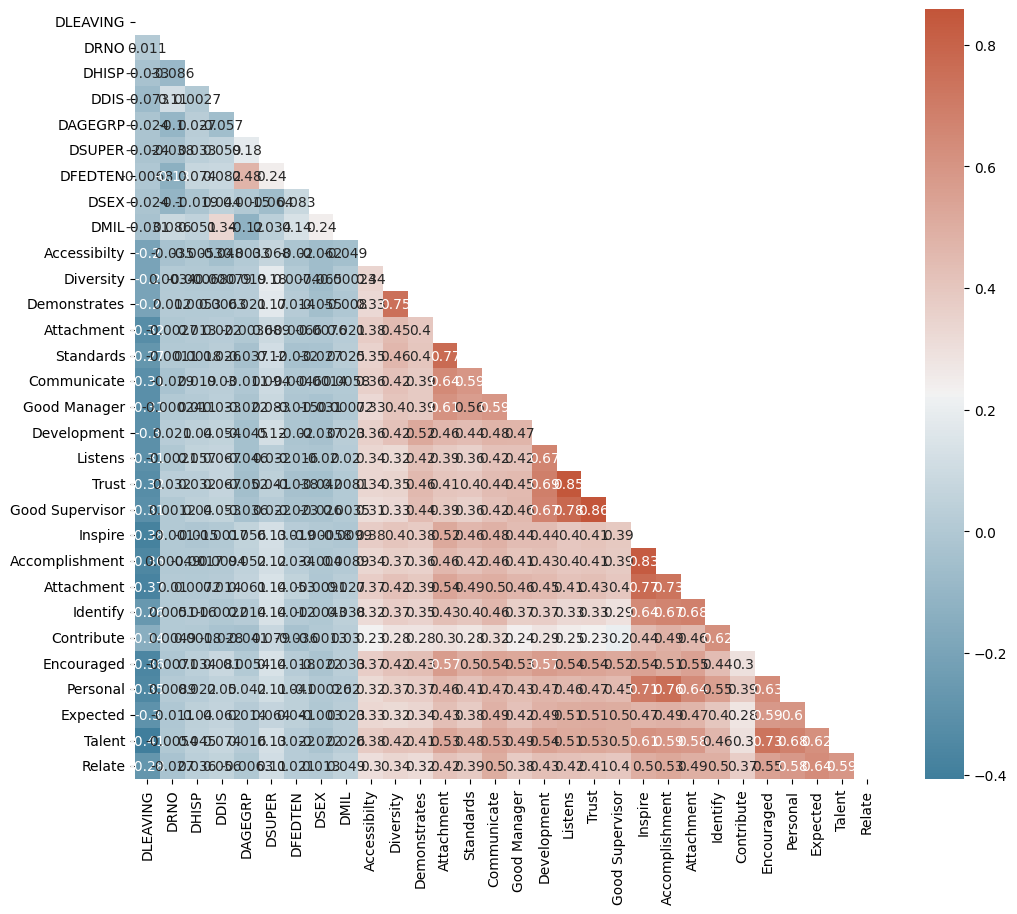

In [17]:
# Create a correlation matrix
updated_correlation_matrix = combined_df.corr()

# Set up the matplotlib plot configuration
ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(updated_correlation_matrix, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(updated_correlation_matrix, annot=True, mask = mask, cmap=cmap)

In [18]:
# Define the features (X) and target variable (y)
features = ['Inspire', 'Accomplishment', 'Attachment', 'Encouraged', 'Expected', 'Relate',
            'Accessibilty', 'Standards', 'Communicate', 'Diversity',
            'Development', 'Listens', 'Trust', 'DAGEGRP', 'DFEDTEN', 'DSEX']


target_variable = 'DLEAVING'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_df[features], 
    combined_df[target_variable], 
    test_size=0.2, 
    random_state=42
)

# Impute NaN values with mean (you can choose another strategy)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#reshape variable
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

#impute NaN
y_train_imputed = imputer.fit_transform(y_train_reshaped).ravel()
y_test_imputed = imputer.transform(y_test_reshaped).ravel()

#round to the nearest integer
# Round continuous values to the nearest integer
y_train_imputed = np.round(y_train_imputed)
y_test_imputed = np.round(y_test_imputed)

# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_imputed, y_train_imputed)
y_pred = logreg.predict(X_test_imputed)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_imputed, y_pred)
accuracy = accuracy_score(y_test_imputed, y_pred)
precision = precision_score(y_test_imputed, y_pred)
recall = recall_score(y_test_imputed, y_pred)
f1 = f1_score(y_test_imputed, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[994  70]
 [279 167]]
Accuracy: 0.7689
Precision: 0.7046
Recall: 0.3744
F1 Score: 0.4890


In [19]:
# Logistic Regression with L2 penalty on imputed data
logreg_l2 = LogisticRegression(penalty='l2', random_state=42)
logreg_l2.fit(X_train_imputed, y_train_imputed)
y_pred_l2 = logreg_l2.predict(X_test_imputed)

# Evaluate the L2 penalty model on imputed data
conf_matrix_l2 = confusion_matrix(y_test_imputed, y_pred_l2)
accuracy_l2 = accuracy_score(y_test_imputed, y_pred_l2)
precision_l2 = precision_score(y_test_imputed, y_pred_l2)
recall_l2 = recall_score(y_test_imputed, y_pred_l2)
f1_l2 = f1_score(y_test_imputed, y_pred_l2)

# Display results for the L2 penalty model on imputed data
print("Confusion Matrix (L2 penalty on imputed data):")
print(conf_matrix_l2)
print(f"Accuracy (L2 penalty on imputed data): {accuracy_l2:.4f}")
print(f"Precision (L2 penalty on imputed data): {precision_l2:.4f}")
print(f"Recall (L2 penalty on imputed data): {recall_l2:.4f}")
print(f"F1 Score (L2 penalty on imputed data): {f1_l2:.4f}")

Confusion Matrix (L2 penalty on imputed data):
[[994  70]
 [279 167]]
Accuracy (L2 penalty on imputed data): 0.7689
Precision (L2 penalty on imputed data): 0.7046
Recall (L2 penalty on imputed data): 0.3744
F1 Score (L2 penalty on imputed data): 0.4890


In [20]:
# Logistic Regression with 'None' penalty
logreg_none = LogisticRegression(random_state=42)
logreg_none.fit(X_train_imputed, y_train_imputed)
y_pred_none = logreg_none.predict(X_test_imputed)

# Logistic Regression with 'l2' penalty
logreg_l2 = LogisticRegression(penalty='l2', random_state=42)
logreg_l2.fit(X_train_imputed, y_train_imputed) 
y_pred_l2 = logreg_l2.predict(X_test_imputed)


# Pseudo R2 Comparison
pseudo_r2_none = logreg_none.score(X_test_imputed, y_test_imputed)  # You can use other pseudo R2 metrics
pseudo_r2_l2 = logreg_l2.score(X_test_imputed, y_test_imputed)

print(f"Pseudo R2 (None): {pseudo_r2_none:.4f}")
print(f"Pseudo R2 (L2): {pseudo_r2_l2:.4f}")

# Coefficient Significance Comparison
coefficients_none = logreg_none.coef_
coefficients_l2 = logreg_l2.coef_

# Compare coefficients and their significance (p-values)
for i, feature in enumerate(features):
    print(f"Feature: {feature}")
    print(f"Coefficient (None): {coefficients_none[0, i]:.4f}")
    print(f"Coefficient (L2): {coefficients_l2[0, i]:.4f}")
    print("")

# Evaluate the models (same as before)
conf_matrix_none = confusion_matrix(y_test_imputed, y_pred_none)
accuracy_none = accuracy_score(y_test_imputed, y_pred_none)
precision_none = precision_score(y_test_imputed, y_pred_none)
recall_none = recall_score(y_test_imputed, y_pred_none)
f1_none = f1_score(y_test_imputed, y_pred_none)

conf_matrix_l2 = confusion_matrix(y_test_imputed, y_pred_l2)
accuracy_l2 = accuracy_score(y_test_imputed, y_pred_l2)
precision_l2 = precision_score(y_test_imputed, y_pred_l2)
recall_l2 = recall_score(y_test_imputed, y_pred_l2)
f1_l2 = f1_score(y_test_imputed, y_pred_l2)



# Display metrics for 'None' penalty model
print("Metrics for 'None' penalty model:")
print("Confusion Matrix:")
print(conf_matrix_none)
print(f"Accuracy: {accuracy_none:.4f}")
print(f"Precision: {precision_none:.4f}")
print(f"Recall: {recall_none:.4f}")
print(f"F1 Score: {f1_none:.4f}")

# Display metrics for 'l2' penalty model
print("\nMetrics for 'l2' penalty model:")
print("Confusion Matrix:")
print(conf_matrix_l2)
print(f"Accuracy: {accuracy_l2:.4f}")
print(f"Precision: {precision_l2:.4f}")
print(f"Recall: {recall_l2:.4f}")
print(f"F1 Score: {f1_l2:.4f}")

Pseudo R2 (None): 0.7689
Pseudo R2 (L2): 0.7689
Feature: Inspire
Coefficient (None): -0.3034
Coefficient (L2): -0.3034

Feature: Accomplishment
Coefficient (None): -0.0724
Coefficient (L2): -0.0724

Feature: Attachment
Coefficient (None): -0.1170
Coefficient (L2): -0.1170

Feature: Encouraged
Coefficient (None): -0.1994
Coefficient (L2): -0.1994

Feature: Expected
Coefficient (None): -0.1632
Coefficient (L2): -0.1632

Feature: Relate
Coefficient (None): -0.0300
Coefficient (L2): -0.0300

Feature: Accessibilty
Coefficient (None): 0.0562
Coefficient (L2): 0.0562

Feature: Standards
Coefficient (None): 0.0046
Coefficient (L2): 0.0046

Feature: Communicate
Coefficient (None): -0.0009
Coefficient (L2): -0.0009

Feature: Diversity
Coefficient (None): -0.0934
Coefficient (L2): -0.0934

Feature: Development
Coefficient (None): 0.0482
Coefficient (L2): 0.0482

Feature: Listens
Coefficient (None): -0.0016
Coefficient (L2): -0.0016

Feature: Trust
Coefficient (None): -0.0961
Coefficient (L2): -0.

In [21]:
# Train a Random Forest model with default parameters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_imputed, y_train_imputed)

# Predictions on the test set
y_pred_rf = rf_model.predict(X_test_imputed)

# Evaluate the model
conf_matrix_rf = confusion_matrix(y_test_imputed, y_pred_rf)
accuracy_rf = accuracy_score(y_test_imputed, y_pred_rf)
precision_rf = precision_score(y_test_imputed, y_pred_rf)
recall_rf = recall_score(y_test_imputed, y_pred_rf)
f1_rf = f1_score(y_test_imputed, y_pred_rf)

# Display metrics for Random Forest model
print("Metrics for Random Forest model:")
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

Metrics for Random Forest model:
Confusion Matrix:
[[967  97]
 [268 178]]
Accuracy: 0.7583
Precision: 0.6473
Recall: 0.3991
F1 Score: 0.4938


In [22]:
# Display metrics for best Logistic Regression model
print("\nMetrics for best Logistic Regression model:")
print("Confusion Matrix:")
print(conf_matrix_none)
print(f"Accuracy: {accuracy_none:.4f}")
print(f"Precision: {precision_none:.4f}")
print(f"Recall: {recall_none:.4f}")
print(f"F1 Score: {f1_none:.4f}")

# Compare with Random Forest
print("\nComparison of Logistic Regression with Random Forest:")
print("Accuracy Comparison:")
print(f"Logistic Regression (None): {accuracy_none:.4f}")
print(f"Random Forest: {accuracy_rf:.4f}")
print("\nPrecision Comparison:")
print(f"Logistic Regression (None): {precision_none:.4f}")
print(f"Random Forest: {precision_rf:.4f}")
print("\nRecall Comparison:")
print(f"Logistic Regression (None): {recall_none:.4f}")
print(f"Random Forest: {recall_rf:.4f}")
print("\nF1 Score Comparison:")
print(f"Logistic Regression (None): {f1_none:.4f}")
print(f"Random Forest: {f1_rf:.4f}")



Metrics for best Logistic Regression model:
Confusion Matrix:
[[994  70]
 [279 167]]
Accuracy: 0.7689
Precision: 0.7046
Recall: 0.3744
F1 Score: 0.4890

Comparison of Logistic Regression with Random Forest:
Accuracy Comparison:
Logistic Regression (None): 0.7689
Random Forest: 0.7583

Precision Comparison:
Logistic Regression (None): 0.7046
Random Forest: 0.6473

Recall Comparison:
Logistic Regression (None): 0.3744
Random Forest: 0.3991

F1 Score Comparison:
Logistic Regression (None): 0.4890
Random Forest: 0.4938


In [26]:
print("Shape of X_test_imputed:", X_test_imputed.shape)
print("Features:", features)


Shape of X_test_imputed: (1510, 17)
Features: ['Inspire', 'Accomplishment', 'Attachment', 'Encouraged', 'Expected', 'Relate', 'Accessibilty', 'Standards', 'Communicate', 'Diversity', 'Development', 'Listens', 'Trust', 'DAGEGRP', 'DFEDTEN', 'DSEX']


In [29]:
features = ['Inspire', 'Accomplishment', 'Attachment', 'Encouraged', 'Expected', 'Relate',
            'Accessibilty', 'Attachment', 'Standards', 'Communicate', 'Diversity',
            'Development', 'Listens', 'Trust', 'DAGEGRP', 'DFEDTEN', 'DSEX']


# Print the shape of X_test_imputed and the length of features
print("Shape of X_test_imputed:", X_test_imputed.shape)
print("Length of features:", len(features))

# Create a DataFrame from the NumPy array with specified column names
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=features)

# Check the column names
column_names = X_test_imputed_df.columns
print("Column Names:", column_names)


Shape of X_test_imputed: (1510, 17)
Length of features: 17
Column Names: Index(['Inspire', 'Accomplishment', 'Attachment', 'Encouraged', 'Expected',
       'Relate', 'Accessibilty', 'Attachment', 'Standards', 'Communicate',
       'Diversity', 'Development', 'Listens', 'Trust', 'DAGEGRP', 'DFEDTEN',
       'DSEX'],
      dtype='object')


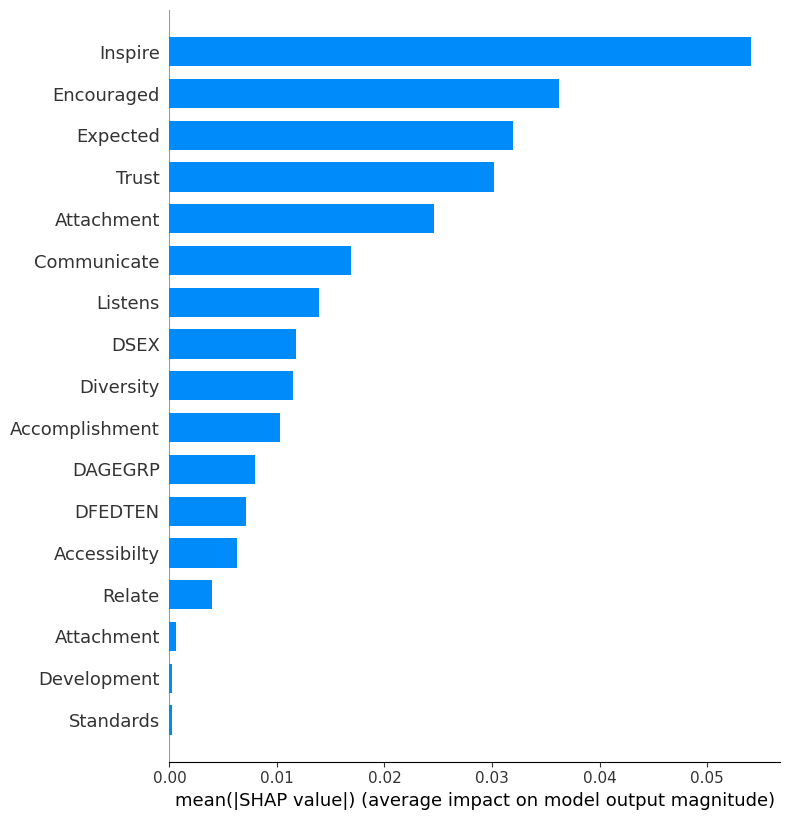

In [30]:
# Define a function that mimics the prediction behavior of the logistic regression model
def logreg_predict_proba(X):
    return logreg_none.predict_proba(X)[:, 1]

# SHAP (SHapley Additive exPlanations) for feature importance visualization
explainer = shap.Explainer(logreg_predict_proba, X_train_imputed)
shap_values = explainer.shap_values(X_test_imputed)

# Summary plot
shap.summary_plot(shap_values, X_test_imputed, feature_names=features, plot_type="bar")
